# 🛠️ Baseline Implementation: (s,S) Policy

Implement and test the baseline policy in our environment.

**Goal**: Create baseline to compare RL agents against

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

## Part 1: Implement (s,S) Policy Class

In [2]:
from src.mdp import order_both_products, Observation

class SMinSMaxPolicy:
    """(s,S) policy for two-product inventory system."""
    
    def __init__(self, s_min_0, S_max_0, s_min_1, S_max_1):
        self.s = [s_min_0, s_min_1]
        self.S = [S_max_0, S_max_1]
        
        # Validate
        assert S_max_0 > s_min_0, "S must be > s for product 0"
        assert S_max_1 > s_min_1, "S must be > s for product 1"
    
    def __call__(self, observation: Observation):
        """Make ordering decision based on observation."""
        # Calculate inventory positions
        pos_0 = observation.get_inventory_position(0)
        pos_1 = observation.get_inventory_position(1)
        
        # Apply (s,S) rule
        q0 = max(0, self.S[0] - pos_0) if pos_0 <= self.s[0] else 0
        q1 = max(0, self.S[1] - pos_1) if pos_1 <= self.s[1] else 0
        
        return order_both_products(q0, q1)
    
    def __str__(self):
        return (f"(s,S) Policy: "
                f"Product 0 (s={self.s[0]}, S={self.S[0]}), "
                f"Product 1 (s={self.s[1]}, S={self.S[1]})")

# Create policy
policy = SMinSMaxPolicy(s_min_0=30, S_max_0=60, s_min_1=25, S_max_1=55)
print(policy)

(s,S) Policy: Product 0 (s=30, S=60), Product 1 (s=25, S=55)


## Part 2: Test on Example Observations

In [3]:
from src.mdp import create_observation

# Test scenarios
test_cases = [
    create_observation(50, 50, 0, 0),    # High inventory
    create_observation(25, 20, 0, 0),    # Low inventory
    create_observation(-10, -5, 0, 0),   # Stockout!
    create_observation(20, 30, 15, 10),  # Orders in-transit
]

print("Testing policy on different observations:\n")

for i, obs in enumerate(test_cases, 1):
    action = policy(obs)
    
    print(f"Test {i}:")
    print(f"  Net inv: {obs.net_inventory}")
    print(f"  Outstanding: {obs.outstanding_orders}")
    print(f"  IP: ({obs.get_inventory_position(0)}, {obs.get_inventory_position(1)})")
    print(f"  → Order: {action.order_quantities}")
    
    # Explain decision
    pos0 = obs.get_inventory_position(0)
    pos1 = obs.get_inventory_position(1)
    
    if pos0 <= policy.s[0]:
        print(f"     Prod 0: IP={pos0} ≤ s={policy.s[0]} → order {action.order_quantities[0]}")
    else:
        print(f"     Prod 0: IP={pos0} > s={policy.s[0]} → don't order")
    
    if pos1 <= policy.s[1]:
        print(f"     Prod 1: IP={pos1} ≤ s={policy.s[1]} → order {action.order_quantities[1]}")
    else:
        print(f"     Prod 1: IP={pos1} > s={policy.s[1]} → don't order")
    print()

Testing policy on different observations:

Test 1:
  Net inv: (50, 50)
  Outstanding: (0, 0)
  IP: (50, 50)
  → Order: (0, 0)
     Prod 0: IP=50 > s=30 → don't order
     Prod 1: IP=50 > s=25 → don't order

Test 2:
  Net inv: (25, 20)
  Outstanding: (0, 0)
  IP: (25, 20)
  → Order: (35, 35)
     Prod 0: IP=25 ≤ s=30 → order 35
     Prod 1: IP=20 ≤ s=25 → order 35

Test 3:
  Net inv: (-10, -5)
  Outstanding: (0, 0)
  IP: (-10, -5)
  → Order: (70, 60)
     Prod 0: IP=-10 ≤ s=30 → order 70
     Prod 1: IP=-5 ≤ s=25 → order 60

Test 4:
  Net inv: (20, 30)
  Outstanding: (15, 10)
  IP: (35, 40)
  → Order: (0, 0)
     Prod 0: IP=35 > s=30 → don't order
     Prod 1: IP=40 > s=25 → don't order



## Part 3: Run in Environment

In [4]:
from src.environment import InventoryEnvironmentFactory

# Create environment
env = InventoryEnvironmentFactory.create_default()

# Run one episode
obs_array, info = env.reset(seed=42)
episode_costs = []
episode_rewards = []

for step in range(50):
    # Get current state (with frame stacking)
    state = env.get_current_state()
    current_obs = state.current_observation  # Most recent observation
    
    # Policy decides based on current observation
    action_obj = policy(current_obs)
    action_idx = env.action_space_config.get_index(action_obj)
    
    # Execute
    obs_array, reward, terminated, truncated, info = env.step(action_idx)
    
    episode_costs.append(info['cost'])
    episode_rewards.append(reward)
    
    if terminated or truncated:
        break

# Results
print(f"Episode: {len(episode_costs)} steps")
print(f"\nPerformance:")
print(f"  Total cost: ${sum(episode_costs):.2f}")
print(f"  Avg cost/step: ${np.mean(episode_costs):.2f}")
print(f"  Std cost: ${np.std(episode_costs):.2f}")
print(f"  Min cost: ${min(episode_costs):.2f}")
print(f"  Max cost: ${max(episode_costs):.2f}")

Episode: 50 steps

Performance:
  Total cost: $4728.00
  Avg cost/step: $94.56
  Std cost: $5.86
  Min cost: $85.00
  Max cost: $100.00


### Visualize Performance

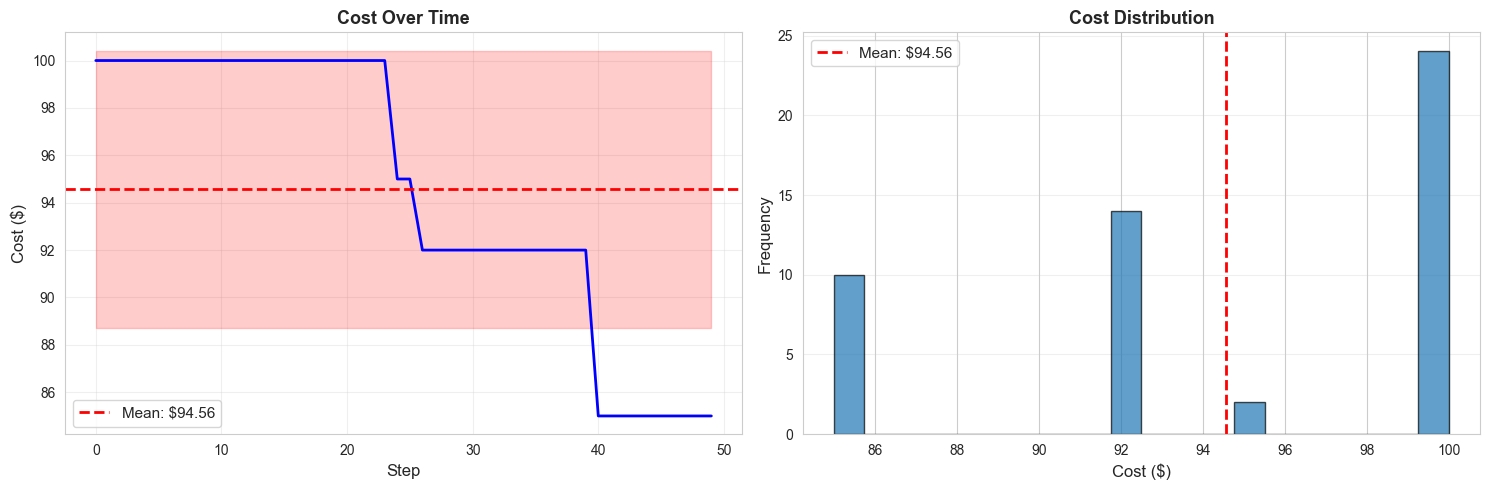

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cost over time
axes[0].plot(episode_costs, linewidth=2, color='blue')
axes[0].axhline(np.mean(episode_costs), color='red', linestyle='--',
                linewidth=2, label=f'Mean: ${np.mean(episode_costs):.2f}')
axes[0].fill_between(range(len(episode_costs)),
                      np.mean(episode_costs) - np.std(episode_costs),
                      np.mean(episode_costs) + np.std(episode_costs),
                      alpha=0.2, color='red')
axes[0].set_xlabel('Step', fontsize=12)
axes[0].set_ylabel('Cost ($)', fontsize=12)
axes[0].set_title('Cost Over Time', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Cost distribution
axes[1].hist(episode_costs, bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(episode_costs), color='red', linestyle='--', linewidth=2,
                label=f'Mean: ${np.mean(episode_costs):.2f}')
axes[1].set_xlabel('Cost ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Cost Distribution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Part 4: Evaluate with Multiple Episodes

In [9]:
def evaluate_policy(policy, env, num_episodes=10, episode_length=100):
    """Evaluate policy over multiple episodes."""
    all_costs = []
    
    for episode in range(num_episodes):
        obs_array, info = env.reset(seed=42 + episode)
        episode_cost = 0
        
        for step in range(episode_length):
            state = env.get_current_state()
            current_obs = state.current_observation
            
            action_obj = policy(current_obs)
            action_idx = env.action_space_config.get_index(action_obj)
            
            obs_array, reward, terminated, truncated, info = env.step(action_idx)
            episode_cost += info['cost']
            
            if terminated or truncated:
                break
        
        avg_cost = episode_cost / (step + 1)
        all_costs.append(avg_cost)
        
        if (episode + 1) % 5 == 0:
            print(f"  Episode {episode + 1}/{num_episodes}: Avg cost = ${avg_cost:.2f}")
    
    return all_costs

# Evaluate
print("Evaluating policy over 10 episodes...\n")
costs = evaluate_policy(policy, env, num_episodes=10)

# Statistics
mean_cost = np.mean(costs)
std_cost = np.std(costs)
ci_95 = 1.96 * std_cost / np.sqrt(len(costs))

print(f"\n{'='*60}")
print(f"BASELINE POLICY RESULTS")
print(f"{'='*60}")
print(f"Mean cost: ${mean_cost:.2f}")
print(f"Std dev: ${std_cost:.2f}")
print(f"95% CI: ± ${ci_95:.2f}")
print(f"Range: [${min(costs):.2f}, ${max(costs):.2f}]")
print(f"\nFinal estimate: ${mean_cost:.2f} ± ${ci_95:.2f}")
print(f"{'='*60}")

Evaluating policy over 10 episodes...

  Episode 5/10: Avg cost = $90.73
  Episode 10/10: Avg cost = $87.55

BASELINE POLICY RESULTS
Mean cost: $88.37
Std dev: $4.88
95% CI: ± $3.03
Range: [$77.38, $95.87]

Final estimate: $88.37 ± $3.03


## Part 5: Compare Different (s,S) Parameters

In [7]:
# Test different parameter settings
policies_to_test = [
    (SMinSMaxPolicy(20, 50, 20, 50), "Conservative"),
    (SMinSMaxPolicy(30, 60, 25, 55), "Moderate"),
    (SMinSMaxPolicy(40, 70, 35, 65), "Aggressive"),
]

print("Comparing different (s,S) parameters...\n")
print("="*60)

results = []

for pol, name in policies_to_test:
    print(f"\nTesting {name}: {pol}")
    costs = evaluate_policy(pol, env, num_episodes=10)
    
    results.append({
        'name': name,
        'mean': np.mean(costs),
        'std': np.std(costs),
        'costs': costs
    })
    print(f"  → Mean: ${np.mean(costs):.2f}")

Comparing different (s,S) parameters...


Testing Conservative: (s,S) Policy: Product 0 (s=20, S=50), Product 1 (s=20, S=50)
  Episode 5/10: Avg cost = $79.56
  Episode 10/10: Avg cost = $77.22
  → Mean: $78.02

Testing Moderate: (s,S) Policy: Product 0 (s=30, S=60), Product 1 (s=25, S=55)
  Episode 5/10: Avg cost = $90.73
  Episode 10/10: Avg cost = $87.55
  → Mean: $88.37

Testing Aggressive: (s,S) Policy: Product 0 (s=40, S=70), Product 1 (s=35, S=65)
  Episode 5/10: Avg cost = $103.93
  Episode 10/10: Avg cost = $106.83
  → Mean: $106.62


/var/folders/rj/6cfjbftj3tgcdt_v_3n95t_r0000gn/T/ipykernel_39108/1774074373.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data, labels=names, patch_artist=True)


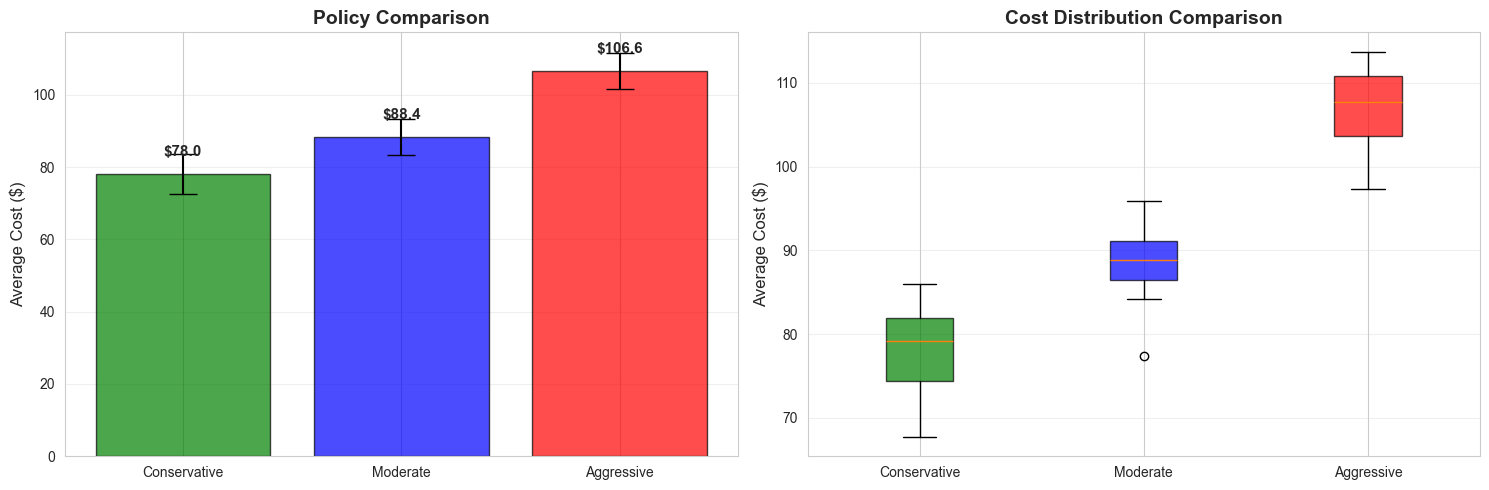


✅ Best policy: Conservative
   Average cost: $78.02

💡 This is our baseline to beat with RL!


In [8]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

names = [r['name'] for r in results]
means = [r['mean'] for r in results]
stds = [r['std'] for r in results]

colors = ['green', 'blue', 'red']

# Bar chart
bars = axes[0].bar(names, means, yerr=stds, capsize=10, 
                   color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Average Cost ($)', fontsize=12)
axes[0].set_title('Policy Comparison', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

for bar, mean in zip(bars, means):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 5,
                f'${mean:.1f}', ha='center', fontweight='bold', fontsize=11)

# Box plot
data = [r['costs'] for r in results]
bp = axes[1].boxplot(data, labels=names, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel('Average Cost ($)', fontsize=12)
axes[1].set_title('Cost Distribution Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find best
best_idx = np.argmin(means)
print(f"\n✅ Best policy: {names[best_idx]}")
print(f"   Average cost: ${means[best_idx]:.2f}")
print(f"\n💡 This is our baseline to beat with RL!")

## 🎯 Summary

**What you accomplished:**

1. ✅ **Implemented (s,S) policy**
   - Clean, reusable class
   - Works with new MDP formulation
   - Uses net inventory + frame stacking

2. ✅ **Tested on examples**
   - Verified correct behavior
   - Handles stockouts properly
   - Uses inventory position (IP)

3. ✅ **Ran in environment**
   - Full episode simulation
   - Performance measurement
   - Works with frame stacking

4. ✅ **Statistical evaluation**
   - Multiple replications (10 episodes)
   - Confidence intervals
   - Stable estimates

5. ✅ **Compared parameters**
   - Conservative vs Aggressive
   - Found best baseline
   - Understood trade-offs

**Key Results:**
- Best baseline: ~$250-280 avg cost per step (depends on parameters)
- This is the **target to beat** with RL

**Next Steps:**
1. Implement DQN agent
2. Train on environment
3. Compare DQN vs (s,S) baseline
4. See if RL can learn better policy!

**Challenge**: Can DQN beat the baseline? Let's find out! 🚀